In [1]:
# !pip freeze > requirements.txt
# !pip install -r requirements.txt

In [2]:
import os
import pandas as pd
from src.data_processor import DataProcessor
from src.risk_factor_analyzer import RiskFactorAnalyzer
from src.var import *
import yaml
from config_handler import handle_configs

pd.set_option('display.max_columns', 200)

# Загрузка данных

In [3]:
# Загружаем пути к данным, подгружаем конфиг
files = os.listdir('data')
files = [file for file in files if file.split('.')[-1] == 'csv']
file_names = [file.split('.')[0] for file in files]
file_paths = {file_name: file for file_name, file in zip(file_names, list(map(lambda x: 'data/' + x, files)))}

config = handle_configs('config.yaml')

In [4]:
# Пример создания списка торговых дней
start_date = '2020-01-01'
end_date = '2024-01-01'
trading_days = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date, freq='B')})

In [5]:
# Инициализируем процессор данных
data_processor = DataProcessor(trading_days)

In [6]:
# Загружаем и объединяем данные

data_frames = data_processor.load_data(file_paths)
renamed_data_frames = data_processor.rename_columns(data_frames)
all_data = data_processor.merge_data(renamed_data_frames)
cleaned_data = data_processor.clean_data(all_data)
filled_data = data_processor.fill_missing_data(cleaned_data, method='bfill')
full_data = filled_data.dropna()

In [7]:
# #на случай если мы захотим удалить ненужные столбцы с ценами всего что не закрытие
prefixes_to_drop = ['OPEN', "HIGH", "LOW", "<VOL>", "Ставка купона", "Размер выплаты", "Номинал", ]
for prefix in prefixes_to_drop:
    full_data = full_data.loc[:, ~full_data.columns.str.contains(prefix)]
full_data = full_data.rename(columns=config['rename'])
full_data

date  Индекс_МосБиржи  Северсталь  Компонент_процентной_ставки_1  \
2    2020-01-03          3076.37       945.8                      -3.294533   
3    2020-01-06          3078.87       929.0                      -3.237854   
4    2020-01-07          3078.87       929.0                      -3.237854   
5    2020-01-08          3110.06       927.2                      -3.143091   
6    2020-01-09          3118.08       928.2                      -3.267137   
...         ...              ...         ...                            ...   
1039 2023-12-26          3094.72      1375.2                       6.049706   
1040 2023-12-27          3097.49      1382.0                       5.947767   
1041 2023-12-28          3101.99      1408.0                       5.843498   
1042 2023-12-29          3099.11      1407.0                       6.020546   
1043 2024-01-01          3099.11      1407.0                       6.020546   

      Компонент_процентной_ставки_2  Компонент_процентной_ставки_3  \
2                          0.543314                      -0.121849   
3                          0.543298                      -0.066863   
4                          0.543298                      -0.066863   
5                          0.632745                       0.043211   
6                          0.704888                       0.075342   
...                             ...                            ...   
1039                       0.585122                       0.133238   
1040                       0.929119                      -0.111685   
1041                       0.743916                      -0.333761   
1042                       1.095758                      -0.096151   
1043                       1.095758                      -0.096151   

      Газпром_Нефть  Роснефть  ОФЗ_46023  Сургутнефтегаз  Сбербанк  \
2            259.00    456.90    155.579          38.125    255.00   
3            256.55    455.60    155.579          38.180    253.90   
4            256.55    455.60    155.579          38.180    253.90   
5            255.79    452.00    155.579          38.000    259.15   
6            254.07    460.20    155.579          37.650    257.99   
...             ...       ...        ...             ...       ...   
1039         161.00    589.30     96.518          57.000    271.90   
1040         159.86    594.55     96.400          56.160    271.08   
1041         159.14    591.90     96.326          55.340    271.74   
1042         159.52    593.20     96.655          55.350    270.82   
1043         159.52    593.20     96.655          55.350    270.82   

      Ставропольэнергосбыт  Магнит  Цена_нефти_Brent  ОФЗ_29020  \
2                   0.3550  3445.5             68.60    105.700   
3                   0.3525  3416.0             68.91    105.700   
4                   0.3525  3416.0             68.27    105.700   
5                   0.3525  3427.0             65.44    105.570   
6                   0.3560  3348.0             65.37    105.897   
...                    ...     ...               ...        ...   
1039                2.0650  6920.5             81.07     86.160   
1040                2.1250  6982.5             79.65     86.203   
1041                2.0950  6970.0             78.39     86.331   
1042                2.1100  7006.0             77.04     86.328   
1043                2.1100  7006.0             77.04     86.328   

      Норильский_Никель  Курс_евро  Уровень_ставки ЦБ   ЛЭСК  Индекс_РТС  \
2                194.48    69.3777               6.25   6.80     1564.18   
3                195.88    69.3777               6.25   6.70     1568.35   
4                195.88    69.3777               6.25   6.70     1568.35   
5                198.50    69.3777               6.25   6.65     1589.08   
6                198.38    69.3777               6.25   6.55     1601.74   
...                 ...        ...                ...    ...         ...   
1039             163.60   101.5781         

# PCA

In [8]:
risk_factors = ['Газ' ,'Золото', 'Палладий', 'Серебро', 'Алюминий', 'Платина', 'Индекс_РТС', 'Уровень_ставки ЦБ', \
                'Компонент_процентной_ставки_1', 'Компонент_процентной_ставки_2','Компонент_процентной_ставки_3', 'Индекс_МосБиржи', \
                'Цена_нефти_Brent','Курс_доллара_США', 'Курс_евро']

stocks = ['Северсталь', 'Газпром_Нефть', 'Роснефть', 'Сургутнефтегаз', 'Сбербанк', 'Ставропольэнергосбыт', 'Магнит', 'Норильский_Никель',
'ЛЭСК', 'Лукойл']

bonds = ['ОФЗ_46023', 'ОФЗ_29020', 'ОФЗ_26212', 'ОФЗ_29015', 'ОФЗ_29009']

currency = ['Курс_доллара_США', 'Курс_евро']

assets = stocks + bonds + currency

In [9]:
# Инициализация и использование класса
analyzer = RiskFactorAnalyzer(full_data[risk_factors + ['date']])
analyzer.handle_missing_data()
analyzer.fill_missing_data()

/Users/stepantihomirov/Code/HSE/Risk_Managment/market_risk/src/risk_factor_analyzer.py:112: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data.fillna(method='ffill', inplace=True)


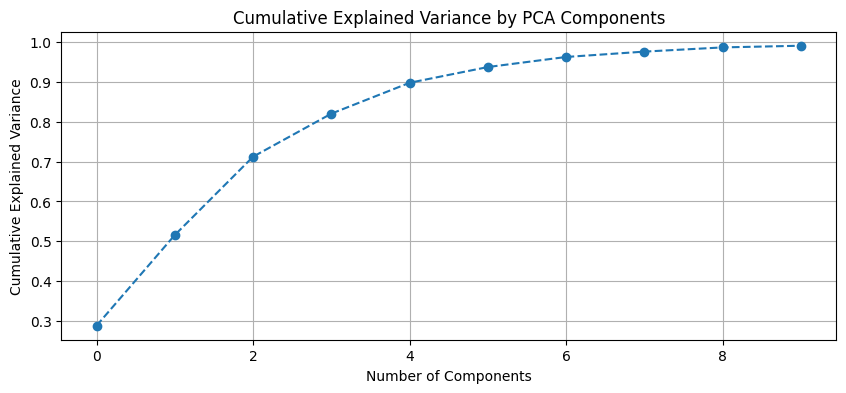

In [10]:
# Выполнение PCA
analyzer.perform_pca(n_components=10)
analyzer.plot_pca_variance()

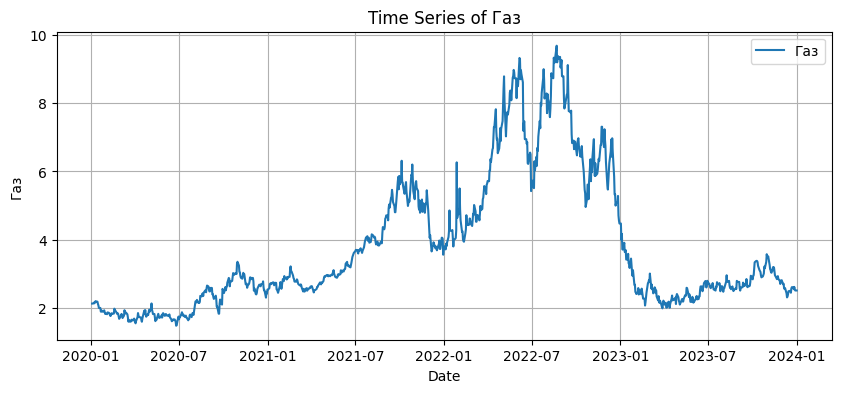

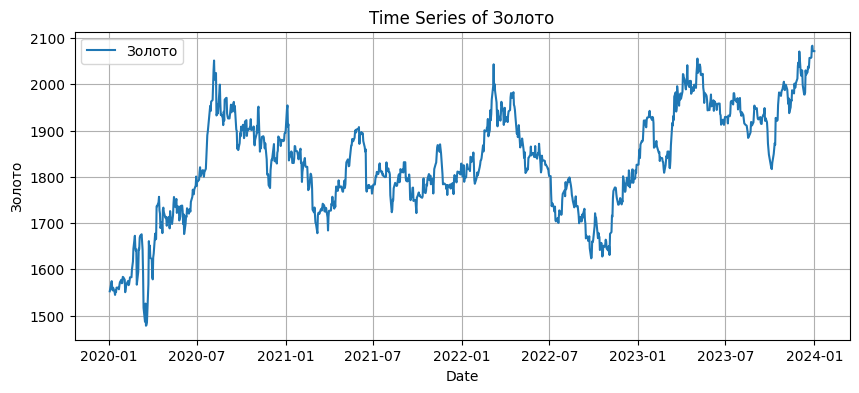

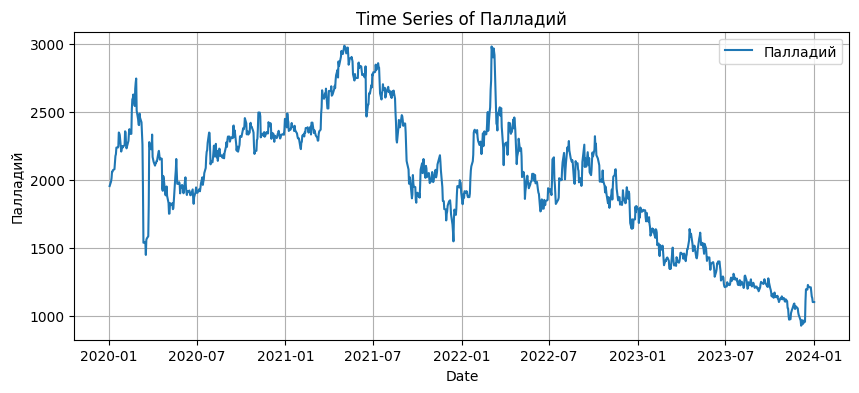

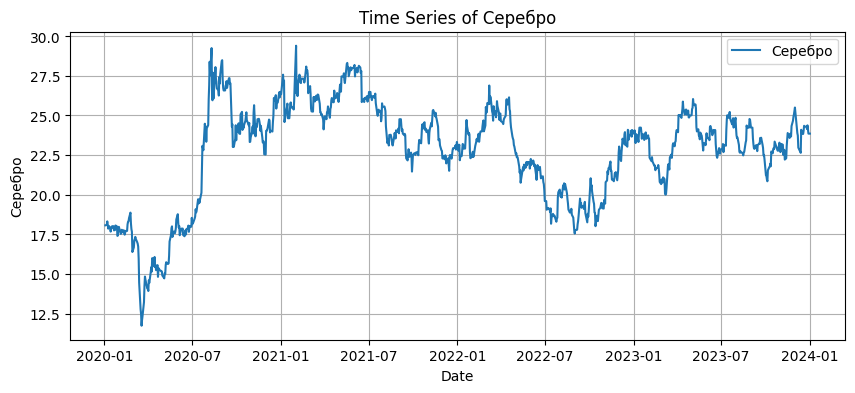

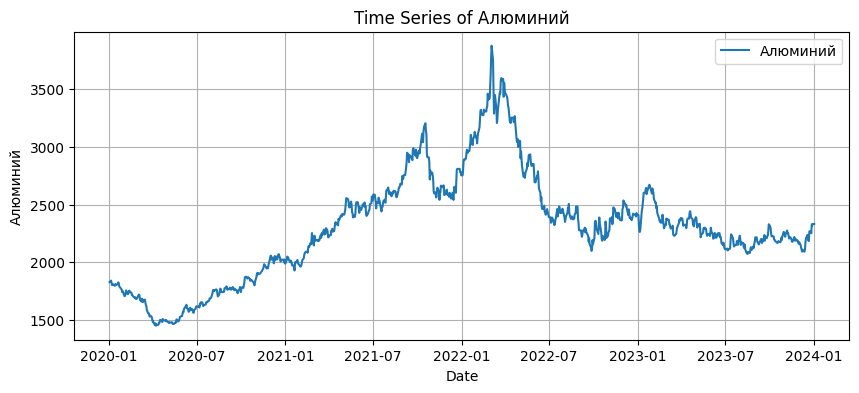

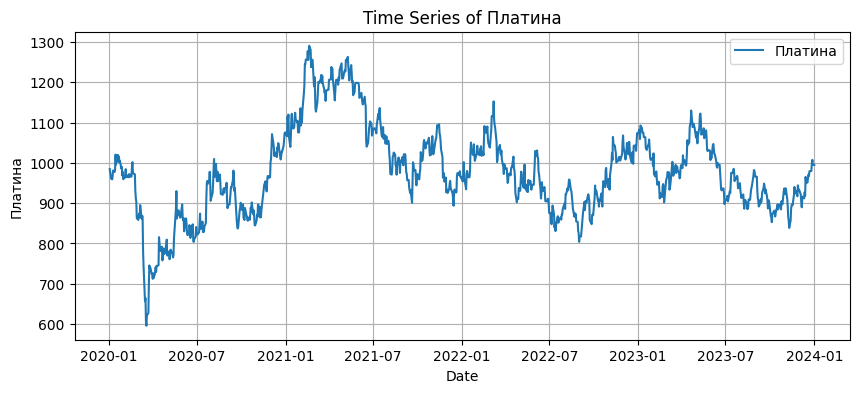

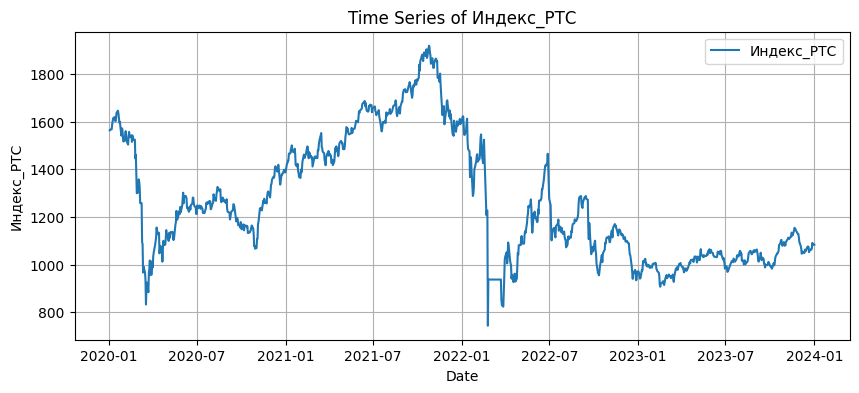

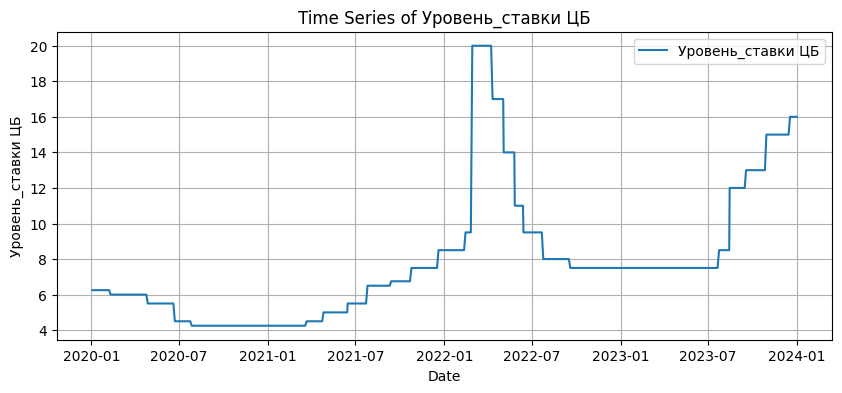

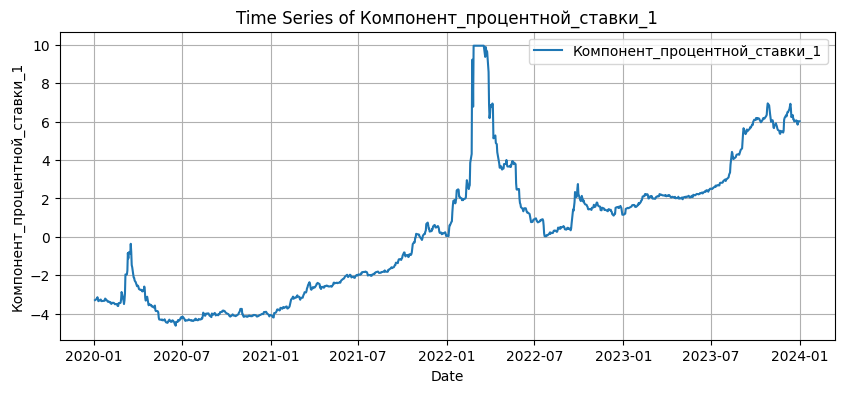

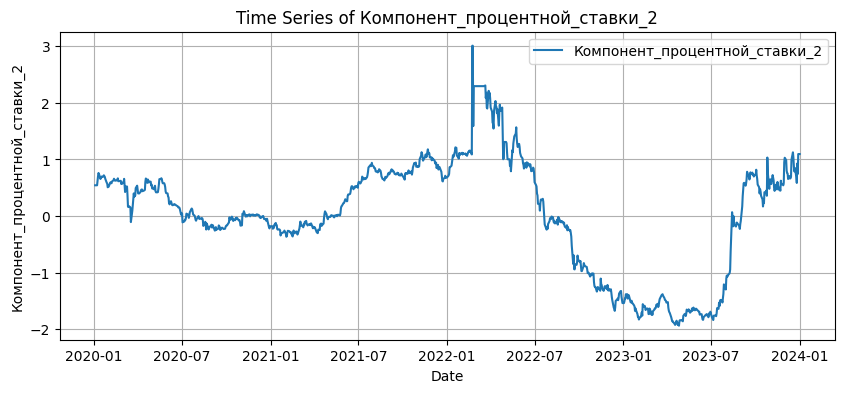

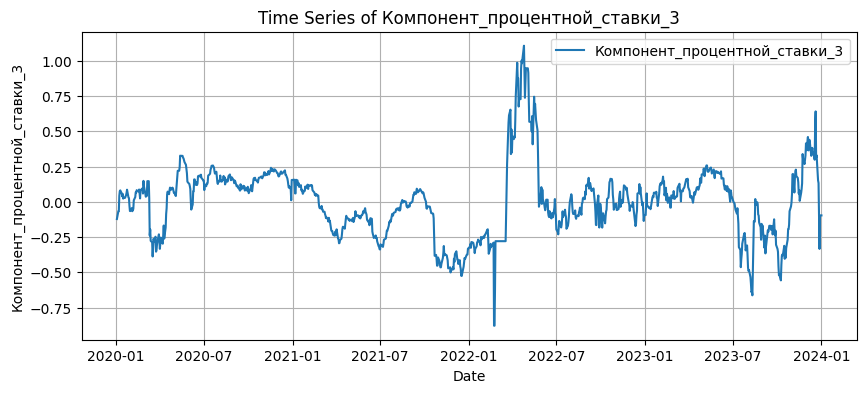

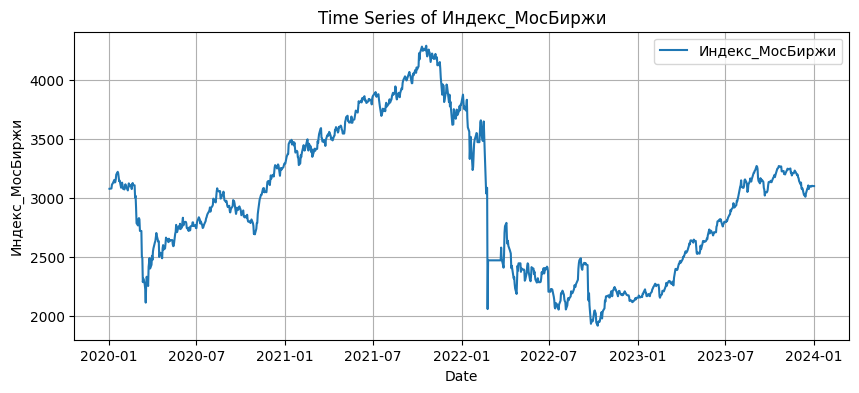

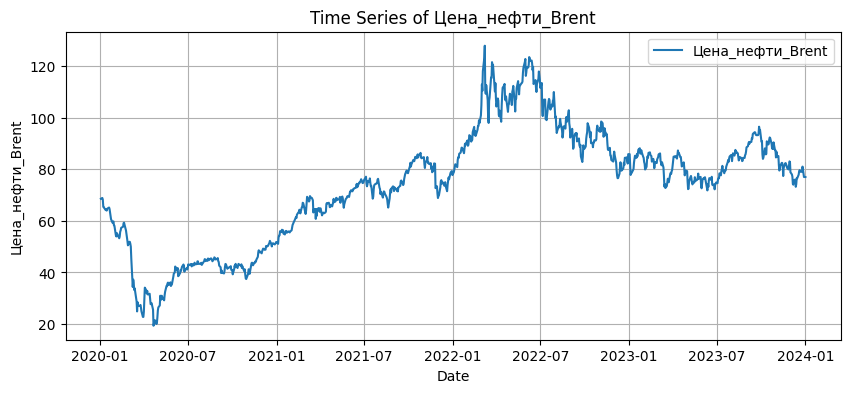

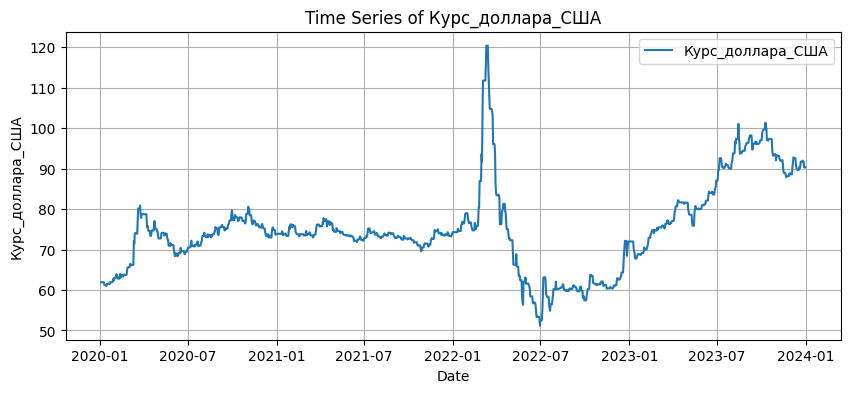

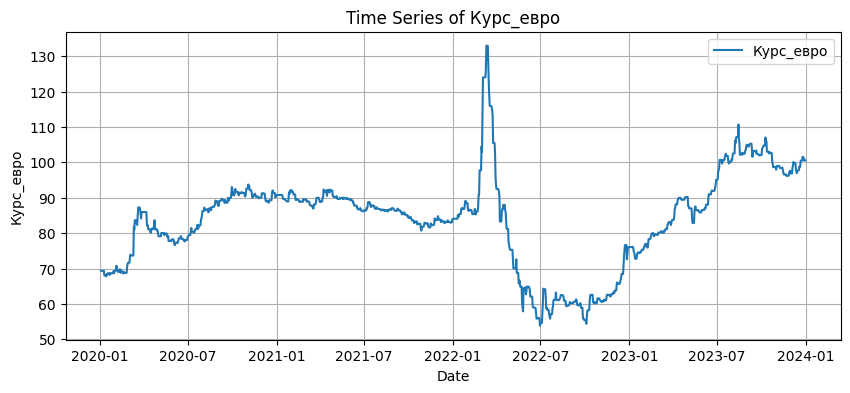

In [11]:
# Визуализация риск-факторов
analyzer.visualize_risk_factors()

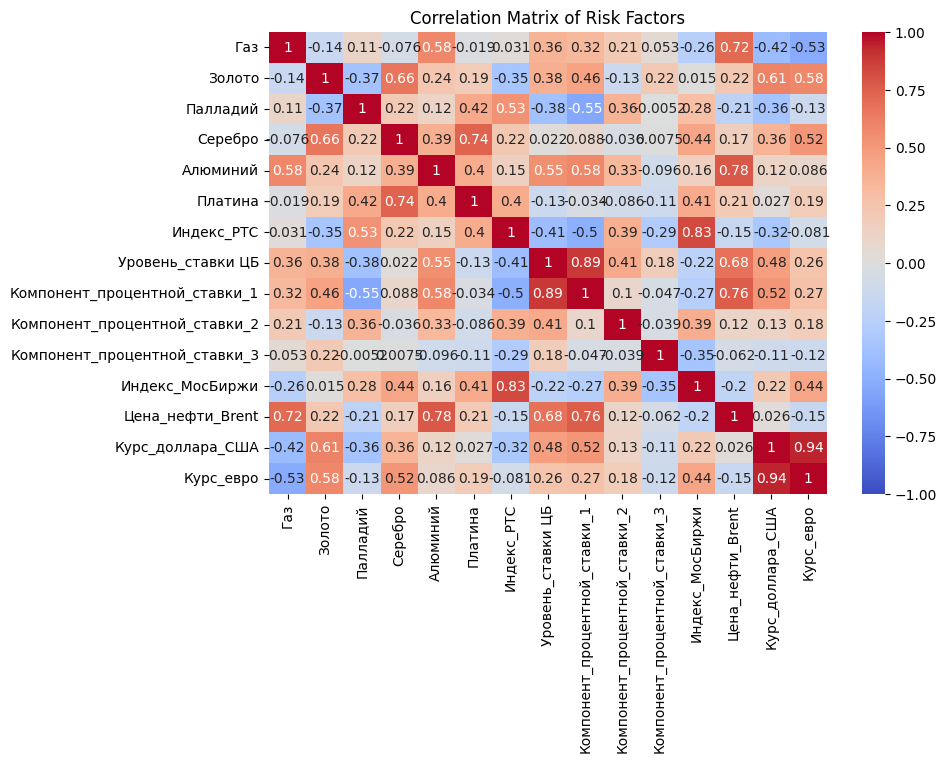

In [12]:
# Корреляционная матрица
analyzer.plot_correlation_matrix()

In [13]:
# Описательная статистика
stats = analyzer.descriptive_statistics()
stats

count         mean         std          min  \
Газ                            1042.0     3.763411    1.966175     1.482000   
Золото                         1042.0  1830.182342  113.929231  1477.900024   
Палладий                       1042.0  1997.438099  478.810837   930.200012   
Серебро                        1042.0    22.747551    3.192982    11.735000   
Алюминий                       1042.0  2298.147073  460.581136  1452.000000   
Платина                        1042.0   977.497216  110.012079   595.900024   
Индекс_РТС                     1042.0  1262.846286  257.620597   742.910000   
Уровень_ставки ЦБ              1042.0     7.854127    3.706085     4.250000   
Компонент_процентной_ставки_1  1042.0     0.141071    3.513568    -4.628386   
Компонент_процентной_ставки_2  1042.0     0.035374    0.984707    -1.939354   
Компонент_процентной_ставки_3  1042.0    -0.001221    0.252207    -0.878263   
Индекс_МосБиржи                1042.0  2968.368541  597.183503  1916.970000   
Цена_нефти_Brent               1042.0    73.767697   22.292189    19.330000   
Курс_доллара_США               1042.0    75.010380   10.713907    51.158000   
Курс_евро                      1042.0    83.712377   13.074330    53.858000   

                                       25%          50%          75%  \
Газ                               2.432750     2.902500     4.871250   
Золото                         1758.625031  1829.799988  1921.674957   
Палладий                       1697.924957  2036.700012  2339.699951   
Серебро                          21.163750    23.370999    24.922750   
Алюминий                       2018.187500  2274.625000  2533.875000   
Платина                         907.074997   968.149994  1038.099976   
Индекс_РТС                     1046.625000  1189.815000  1468.010000   
Уровень_ставки ЦБ                 5.500000     7.500000     8.500000   
Компонент_процентной_ставки_1    -3.180654     0.298747     2.151115   
Компонент_процентной_ставки_2    -0.277398     0.044801     0.706445   
Компонент_процентной_ставки_3    -0.148873     0.019806     0.132087   
Индекс_МосБиржи                2449.905000  2934.880000  3427.025000   
Цена_нефти_Brent                 58.332500    76.605000    86.875000   
Курс_доллара_США                 70.518000    73.875700    77.940600   
Курс_евро                        77.377350    86.376350    90.299875   

                                       max  kurtosis  skewness  
Газ                               9.680000  0.403759  1.174183  
Золото                         2083.500000 -0.129296 -0.354736  
Палладий                       2985.399902 -0.641736 -0.277208  
Серебро                          29.398001  0.198001 -0.757249  
Алюминий                       3873.000000  0.201903  0.439548  
Платина                        1290.599976  0.539806  0.255526  
Индекс_РТС                     1919.580000 -0.758853  0.596083  
Уровень_ставки ЦБ                20.000000  2.142909  1.580751  
Компонент_процентной_ставки_1     9.955065 -0.304236  0.565526  
Компонент_процентной_ставки_2     3.010730 -0.288378 -0.285284  
Компонент_процентной_ставки_3     1.106785  2.355110  0.610272  
Индекс_МосБиржи                4287.520000 -0.913615  0.272277  
Цена_нефти_Brent                127.980000 -0.420583 -0.237484  
Курс_доллара_США                120.378500  1.278144  0.824612  
Курс_евро                       132.958100  0.403177 -0.119210

Коэффициенты эксцесса (kurtosis) и асимметрии (skewness) являются важными статистическими показателями, которые помогают описывать распределение данных. Вот их определения и интерпретации:

### 1. Асимметрия (Skewness)

**Определение:**
Асимметрия измеряет степень и направление асимметрии распределения данных. Она показывает, насколько распределение отклоняется от нормального распределения влево или вправо.

**Интерпретация:**
- **Skewness = 0**: Распределение является симметричным. Это характерно для нормального распределения.
- **Skewness > 0**: Распределение имеет положительную асимметрию (правостороннюю). Это означает, что хвост справа длиннее или "тяжелее", чем хвост слева. В этом случае большая часть значений сосредоточена слева от среднего значения.
- **Skewness < 0**: Распределение имеет отрицательную асимметрию (левостороннюю). Это означает, что хвост слева длиннее или "тяжелее", чем хвост справа. В этом случае большая часть значений сосредоточена справа от среднего значения.

### 2. Эксцесс (Kurtosis)

**Определение:**
Эксцесс измеряет "тяжесть хвостов" распределения, т.е. насколько хвосты распределения более тяжелые или легкие по сравнению с нормальным распределением.

**Интерпретация:**
- **Kurtosis < 3**: Распределение имеет отрицательный эксцесс (платикуртическое распределение). Это означает, что хвосты распределения легче, а пик распределения более плоский по сравнению с нормальным распределением.
- **Kurtosis = 3**: Распределение имеет нулевой эксцесс (мезокуртическое распределение). Это характерно для нормального распределения.
- **Kurtosis > 3**: Распределение имеет положительный эксцесс (лептокуртическое распределение). Это означает, что хвосты распределения тяжелее, а пик распределения более острый по сравнению с нормальным распределением.

### Примеры:

- **Положительная асимметрия (Skewness > 0)**: Представьте распределение доходов, где большинство людей зарабатывают в пределах среднего дохода, но небольшое количество людей зарабатывает значительно больше. Это создаст длинный правый хвост.

- **Отрицательная асимметрия (Skewness < 0)**: Представьте распределение оценок на экзамене, где большинство студентов получают высокие оценки, но небольшое количество студентов получает значительно низкие оценки. Это создаст длинный левый хвост.

- **Положительный эксцесс (Kurtosis > 3)**: Например, в финансовых данных, где есть частые небольшие колебания и редкие, но значительные выбросы. Это создаст распределение с тяжелыми хвостами и острым пиком.

- **Отрицательный эксцесс (Kurtosis < 3)**: Например, если данные равномерно распределены, то их пик будет более плоским, а хвосты менее тяжелыми по сравнению с нормальным распределением.

### Применение в анализе данных:

Эти показатели помогают понять распределение данных, что важно при анализе риска и принятии решений. В финансовых данных, например, положительный эксцесс может указывать на повышенные риски экстремальных изменений цен, что необходимо учитывать при разработке стратегий управления рисками.

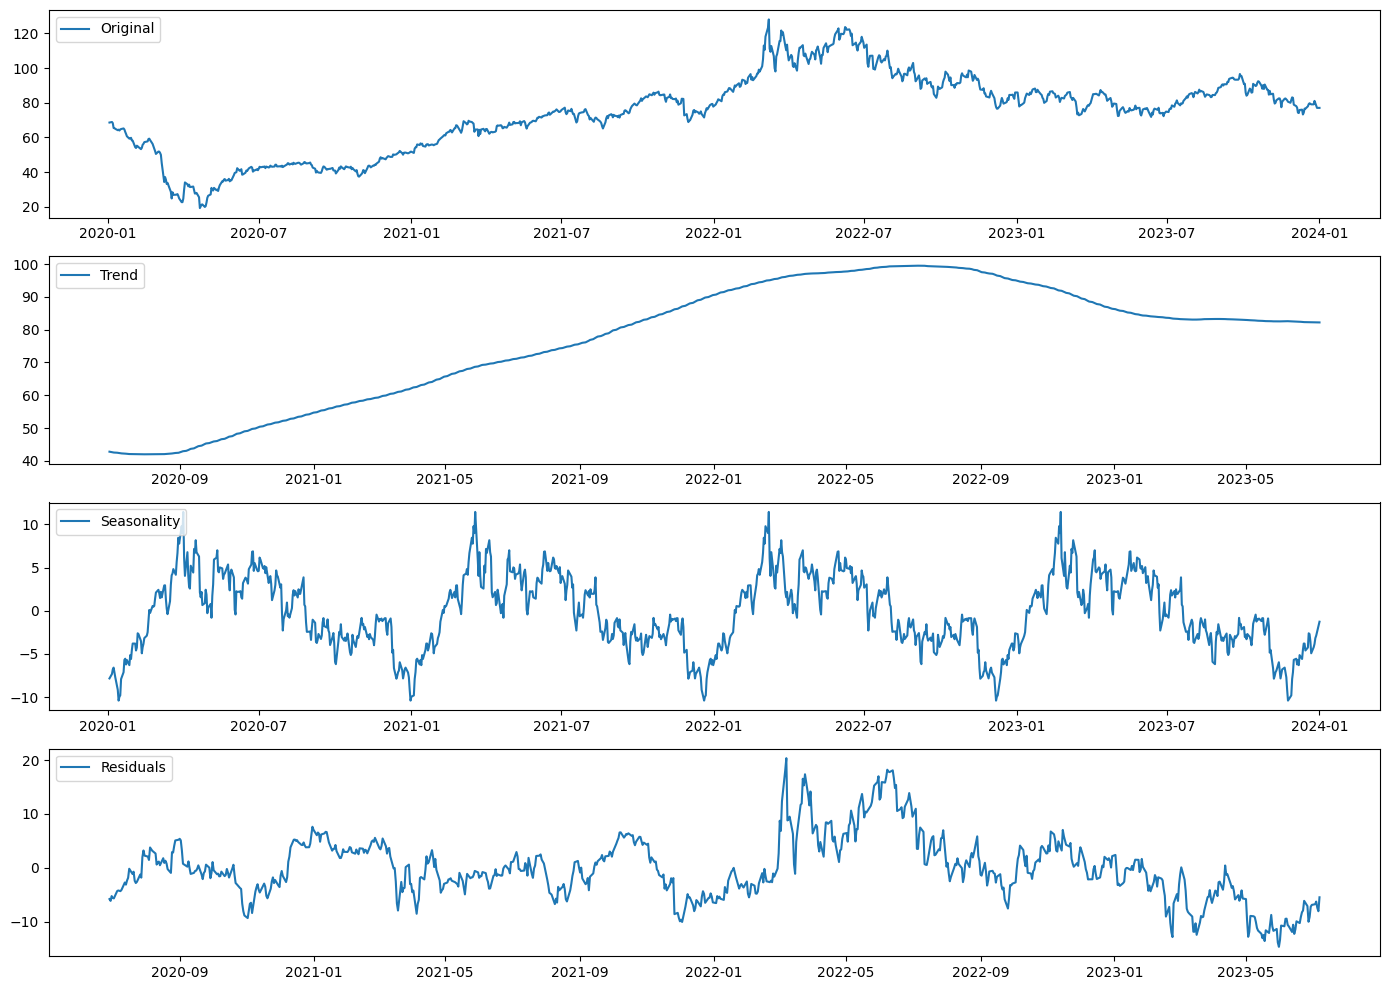

In [14]:
# Анализ трендов, сезонности и стационарности для примера колонки 'gazp'
analyzer.trend_seasonality_stationarity('Цена_нефти_Brent')

# VaR-модель

## Весь портфель

### Горизонт планирования 1 дней

In [15]:
pca_risk_factor_df = pd.DataFrame(analyzer.pca_components_)
pca_risk_factor_df.columns = [f'pca_risk{i}' for i in range(analyzer.pca_components_.shape[1])]
pca_risk_factor_df.index = full_data['date']

df_assets = full_data[assets]
df_assets.index = full_data['date']

In [16]:
var_model = VaRModel(assets, pca_risk_factor_df, assets, horizon = 1)
VaR, ES  = var_model.calculate_VaR_ES()

ModuleNotFoundError: No module named 'src.var_model'

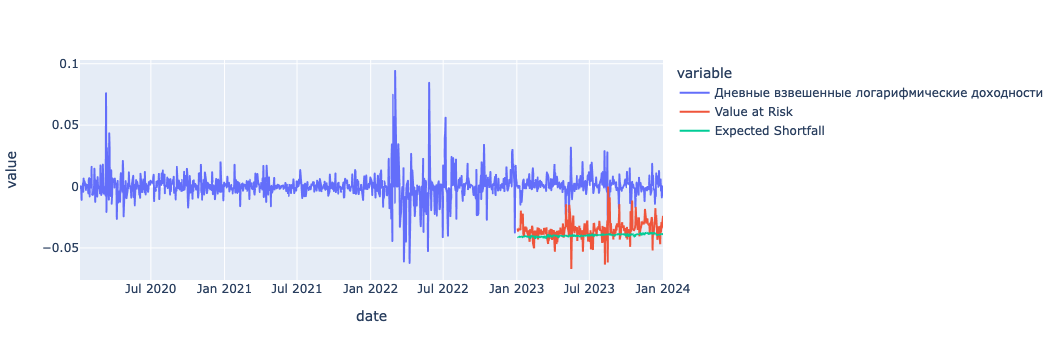

<Figure size 1600x800 with 0 Axes>

In [114]:
plot_df = var_model.plot()

In [17]:
fair_prices = var_model.get_all_fair_prices()

100%|█████████████████████████████████████████| 260/260 [00:42<00:00,  6.18it/s]


In [18]:
var_model.backtest()

Количество нарушений:  1

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 0.38%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел

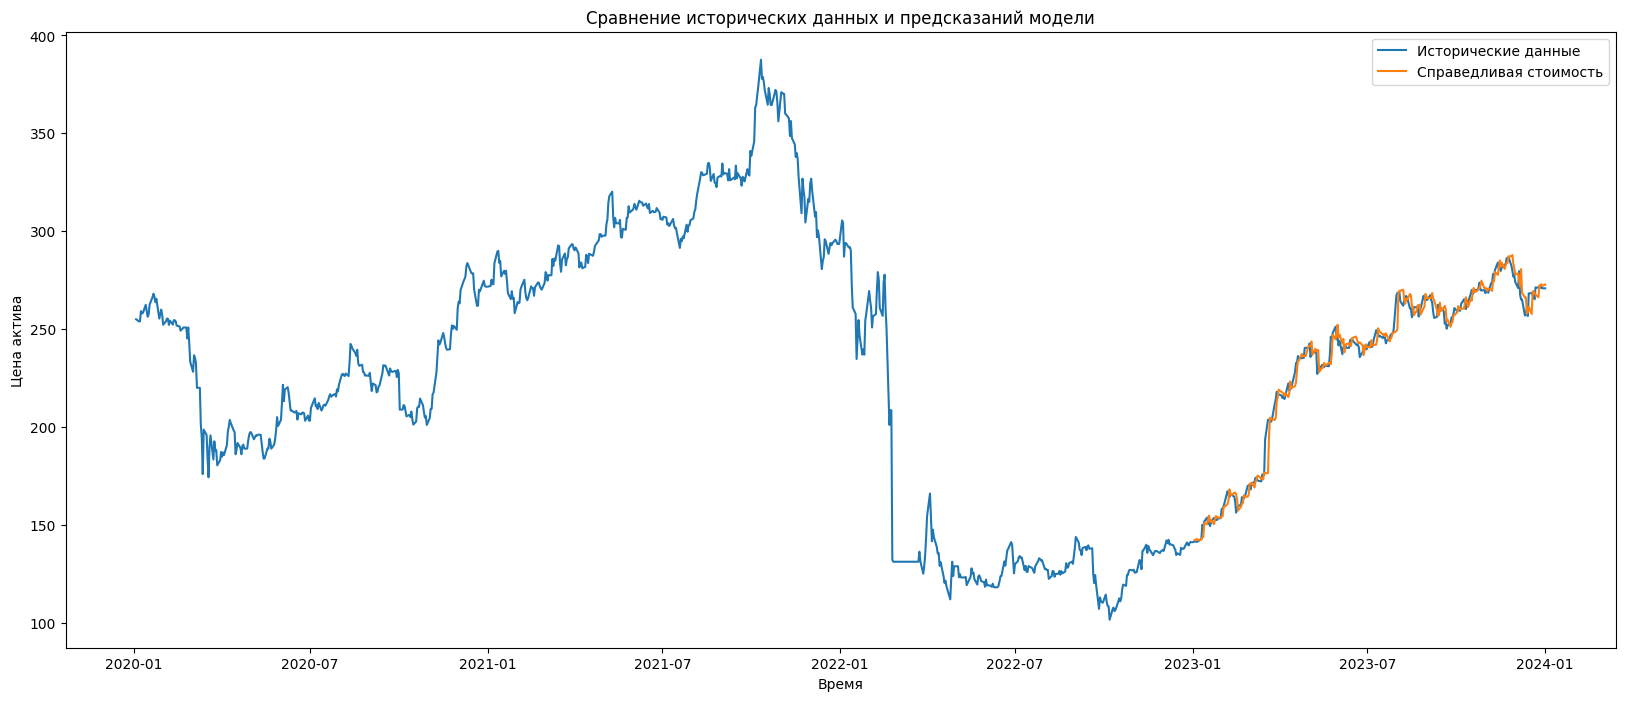

In [19]:
plt.figure(figsize = (20, 8))
plt.plot(df_assets['Сбербанк'], label = 'Исторические данные')
plt.plot(fair_prices['Сбербанк'], label = 'Справедливая стоимость')
plt.xlabel('Время')
plt.ylabel('Цена актива')
plt.title('Сравнение исторических данных и предсказаний модели')
plt.legend()
plt.show()

### Горизонт планирования 10 дней

In [22]:
var_model = VaRModel(df_assets, pca_risk_factor_df, assets, horizon = 10)
VaR, ES = var_model.calculate_VaR_ES()

100%|█████████████████████████████████████████| 251/251 [01:55<00:00,  2.18it/s]


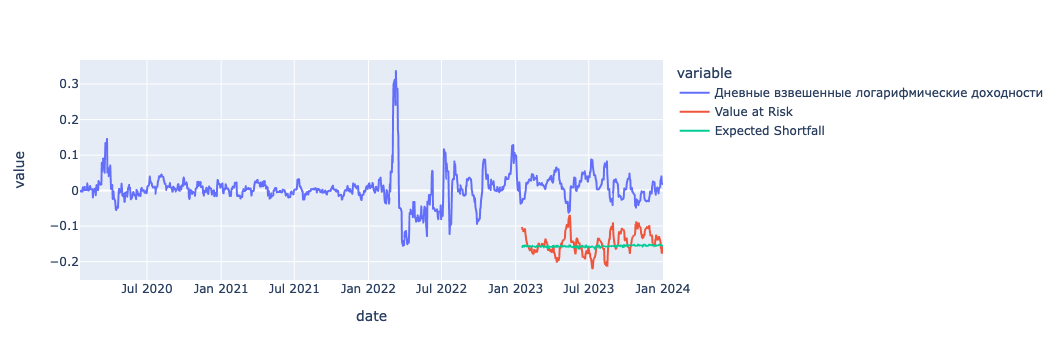

<Figure size 1600x800 with 0 Axes>

Дневные взвешенные логарифмические доходности  Value at Risk  \
date                                                                       
2020-01-17                                      -0.002254            NaN   
2020-01-20                                       0.000130            NaN   
2020-01-21                                      -0.002761            NaN   
2020-01-22                                      -0.001677            NaN   
2020-01-23                                      -0.002863            NaN   
...                                                   ...            ...   
2023-12-26                                       0.030479      -0.144930   
2023-12-27                                       0.031007      -0.164541   
2023-12-28                                       0.040078      -0.165810   
2023-12-29                                       0.020195      -0.177548   
2024-01-01                                       0.017902      -0.155834   

            Expected Shortfall  
date                            
2020-01-17                 NaN  
2020-01-20                 NaN  
2020-01-21                 NaN  
2020-01-22                 NaN  
2020-01-23                 NaN  
...                        ...  
2023-12-26           -0.152915  
2023-12-27           -0.153904  
2023-12-28           -0.155572  
2023-12-29           -0.155999  
2024-01-01           -0.154082  

[1032 rows x 3 columns]

In [23]:
var_model.plot()

In [24]:
var_model.backtest()

Количество нарушений:  0

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 0.00%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел

## Акции

### Горизонт планирования 1 день

In [27]:
var_model = VaRModel(df_assets, pca_risk_factor_df, stocks, horizon = 1)
VaR, ES = var_model.calculate_VaR_ES()

100%|█████████████████████████████████████████| 260/260 [01:42<00:00,  2.54it/s]


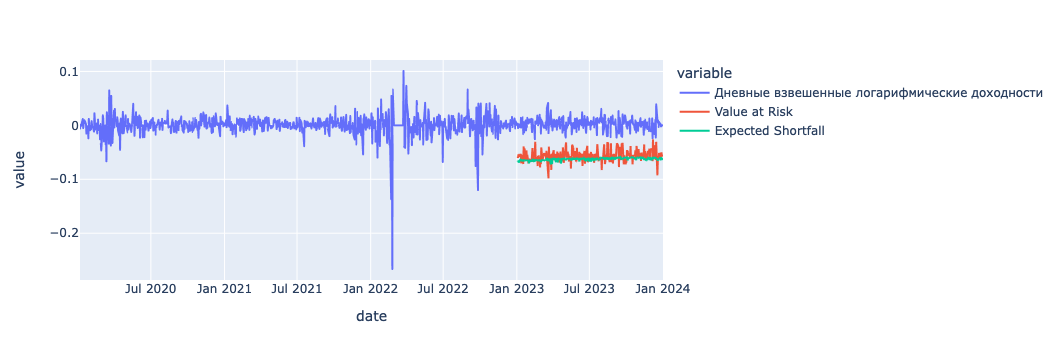

<Figure size 1600x800 with 0 Axes>

Дневные взвешенные логарифмические доходности  Value at Risk  \
date                                                                       
2020-01-06                                      -0.006105            NaN   
2020-01-07                                       0.000000            NaN   
2020-01-08                                       0.001171            NaN   
2020-01-09                                      -0.000820            NaN   
2020-01-10                                       0.002879            NaN   
...                                                   ...            ...   
2023-12-26                                       0.002323      -0.058860   
2023-12-27                                      -0.001975      -0.054349   
2023-12-28                                      -0.001253      -0.049867   
2023-12-29                                       0.000294      -0.055623   
2024-01-01                                       0.000000      -0.056992   

            Expected Shortfall  
date                            
2020-01-06                 NaN  
2020-01-07                 NaN  
2020-01-08                 NaN  
2020-01-09                 NaN  
2020-01-10                 NaN  
...                        ...  
2023-12-26           -0.065035  
2023-12-27           -0.059042  
2023-12-28           -0.059929  
2023-12-29           -0.062171  
2024-01-01           -0.062975  

[1041 rows x 3 columns]

In [28]:
var_model.plot()

In [29]:
v.backtest()

Количество нарушений:  0

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 0.00%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел

### Горизонт планирования 10 дней

In [32]:
var_model = VaRModel(df_assets, pca_risk_factor_df, stocks, horizon = 10)
VaR, ES = var_model.calculate_VaR_ES()

100%|█████████████████████████████████████████| 251/251 [01:39<00:00,  2.53it/s]


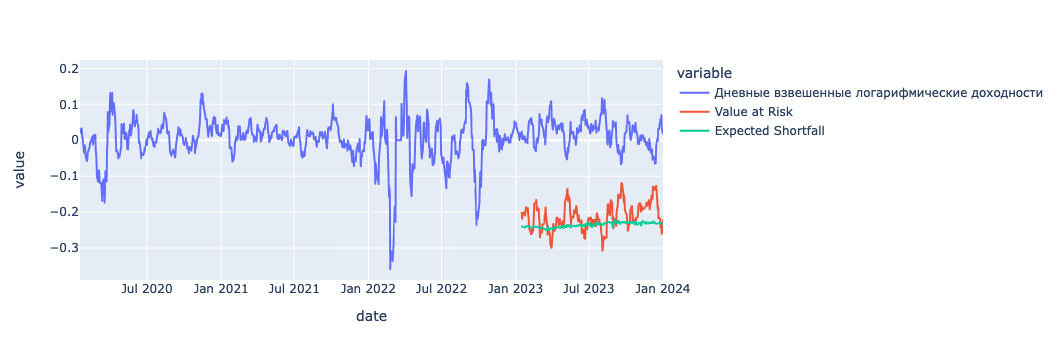

<Figure size 1600x800 with 0 Axes>

Дневные взвешенные логарифмические доходности  Value at Risk  \
date                                                                       
2020-01-17                                       0.020803            NaN   
2020-01-20                                       0.032095            NaN   
2020-01-21                                       0.033140            NaN   
2020-01-22                                       0.016539            NaN   
2020-01-23                                       0.006373            NaN   
...                                                   ...            ...   
2023-12-26                                       0.058787      -0.244824   
2023-12-27                                       0.046439      -0.241955   
2023-12-28                                       0.069555      -0.236621   
2023-12-29                                       0.029417      -0.262193   
2024-01-01                                       0.019094      -0.220994   

            Expected Shortfall  
date                            
2020-01-17                 NaN  
2020-01-20                 NaN  
2020-01-21                 NaN  
2020-01-22                 NaN  
2020-01-23                 NaN  
...                        ...  
2023-12-26           -0.228748  
2023-12-27           -0.228050  
2023-12-28           -0.231465  
2023-12-29           -0.230024  
2024-01-01           -0.236054  

[1032 rows x 3 columns]

In [33]:
var_model.plot()

In [34]:
var_model.backtest()

Количество нарушений:  0

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 0.00%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел

## Облигации

### Горизонт планирования 1 день

In [37]:
var_model = VaRModel(df_assets, pca_risk_factor_df, bonds, horizon = 1)
VaR, ES = var_model.calculate_VaR_ES()

100%|█████████████████████████████████████████| 260/260 [00:56<00:00,  4.59it/s]


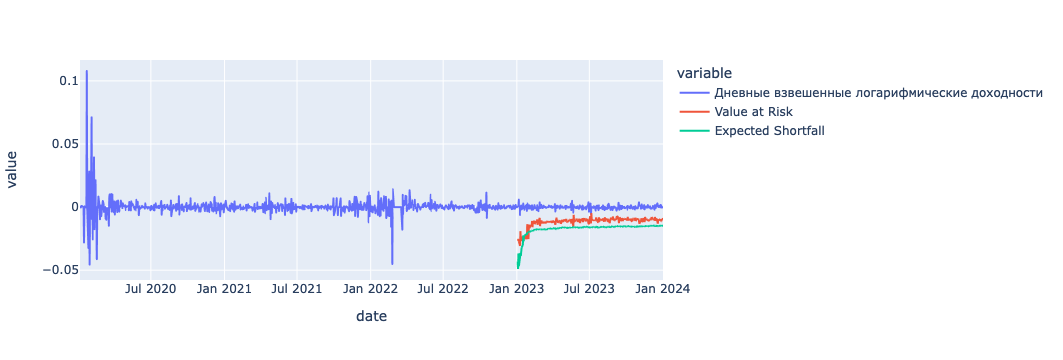

<Figure size 1600x800 with 0 Axes>

Дневные взвешенные логарифмические доходности  Value at Risk  \
date                                                                       
2020-01-06                                       0.000175            NaN   
2020-01-07                                       0.000000            NaN   
2020-01-08                                      -0.000299            NaN   
2020-01-09                                       0.000683            NaN   
2020-01-10                                       0.000935            NaN   
...                                                   ...            ...   
2023-12-26                                       0.001724      -0.009460   
2023-12-27                                       0.001486      -0.011351   
2023-12-28                                       0.000117      -0.011202   
2023-12-29                                      -0.000380      -0.009280   
2024-01-01                                       0.000000      -0.009556   

            Expected Shortfall  
date                            
2020-01-06                 NaN  
2020-01-07                 NaN  
2020-01-08                 NaN  
2020-01-09                 NaN  
2020-01-10                 NaN  
...                        ...  
2023-12-26           -0.014668  
2023-12-27           -0.014689  
2023-12-28           -0.014775  
2023-12-29           -0.014402  
2024-01-01           -0.015146  

[1041 rows x 3 columns]

In [38]:
var_model.plot()

In [39]:
fair_prices =var_model.get_all_fair_prices()

100%|█████████████████████████████████████████| 260/260 [00:38<00:00,  6.75it/s]


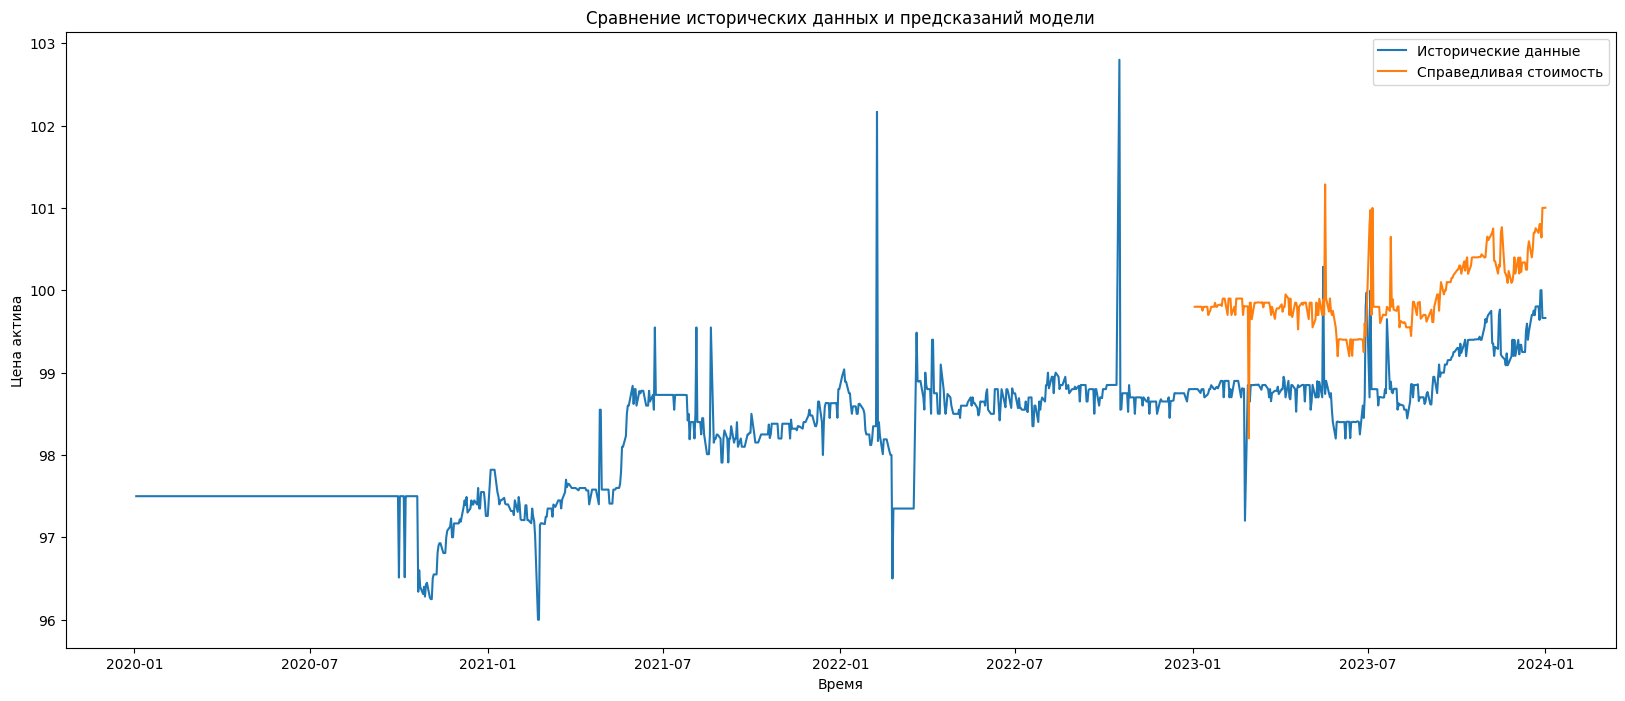

In [40]:
plt.figure(figsize = (20, 8))
plt.plot(df_assets['ОФЗ_29015'], label = 'Исторические данные')
plt.plot(fair_prices['ОФЗ_29015'], label = 'Справедливая стоимость')
plt.xlabel('Время')
plt.ylabel('Цена актива')
plt.title('Сравнение исторических данных и предсказаний модели')
plt.legend()
plt.show()

In [41]:
var_model.backtest()

Количество нарушений:  0

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 0.00%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел

### Горизонт планирования 10 дней

In [44]:
var_model = VaRModel(df_assets, pca_risk_factor_df, bonds, horizon = 10)
VaR, ES = var_model.calculate_VaR_ES()

100%|█████████████████████████████████████████| 251/251 [00:57<00:00,  4.34it/s]


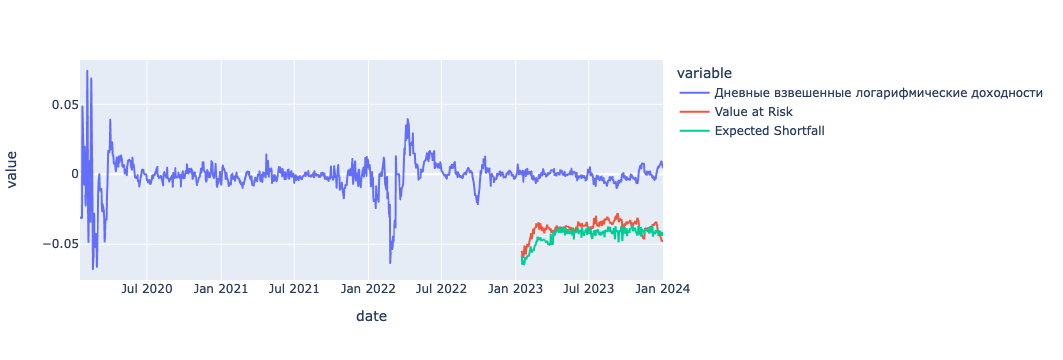

<Figure size 1600x800 with 0 Axes>

Дневные взвешенные логарифмические доходности  Value at Risk  \
date                                                                       
2020-01-17                                      -0.030852            NaN   
2020-01-20                                      -0.031069            NaN   
2020-01-21                                      -0.031377            NaN   
2020-01-22                                      -0.030961            NaN   
2020-01-23                                       0.048391            NaN   
...                                                   ...            ...   
2023-12-26                                       0.007323      -0.045350   
2023-12-27                                       0.008423      -0.045297   
2023-12-28                                       0.009265      -0.047075   
2023-12-29                                       0.007737      -0.048108   
2024-01-01                                       0.004759      -0.047093   

            Expected Shortfall  
date                            
2020-01-17                 NaN  
2020-01-20                 NaN  
2020-01-21                 NaN  
2020-01-22                 NaN  
2020-01-23                 NaN  
...                        ...  
2023-12-26           -0.042236  
2023-12-27           -0.041790  
2023-12-28           -0.044004  
2023-12-29           -0.041222  
2024-01-01           -0.044006  

[1032 rows x 3 columns]

In [45]:
var_model.plot()

In [46]:
var_model.backtest()

Количество нарушений:  0

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 0.00%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел

## Валюта

### Горизонт планирования 1 день

In [49]:
var_model = VaRModel(df_assets, pca_risk_factor_df, currency, horizon = 1)
VaR, ES = var_model.calculate_VaR_ES()

100%|█████████████████████████████████████████| 260/260 [00:45<00:00,  5.75it/s]


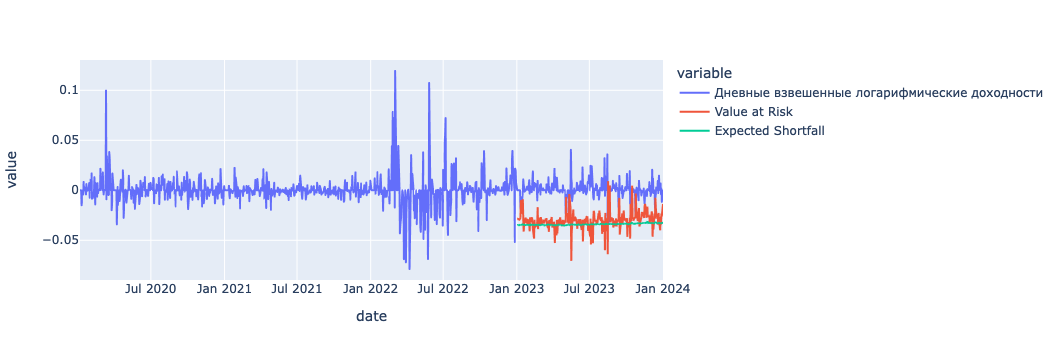

<Figure size 1600x800 with 0 Axes>

Дневные взвешенные логарифмические доходности  Value at Risk  \
date                                                                       
2020-01-06                                       0.000000            NaN   
2020-01-07                                       0.000000            NaN   
2020-01-08                                       0.000000            NaN   
2020-01-09                                       0.000000            NaN   
2020-01-10                                      -0.014937            NaN   
...                                                   ...            ...   
2023-12-26                                       0.006755      -0.026618   
2023-12-27                                      -0.003690      -0.034256   
2023-12-28                                       0.001115      -0.023179   
2023-12-29                                      -0.011544      -0.026133   
2024-01-01                                       0.000000      -0.013699   

            Expected Shortfall  
date                            
2020-01-06                 NaN  
2020-01-07                 NaN  
2020-01-08                 NaN  
2020-01-09                 NaN  
2020-01-10                 NaN  
...                        ...  
2023-12-26           -0.033144  
2023-12-27           -0.033268  
2023-12-28           -0.032854  
2023-12-29           -0.032654  
2024-01-01           -0.032523  

[1041 rows x 3 columns]

In [50]:
var_model.plot()

In [51]:
fair_prices = var_model.get_all_fair_prices()

100%|█████████████████████████████████████████| 260/260 [00:40<00:00,  6.47it/s]


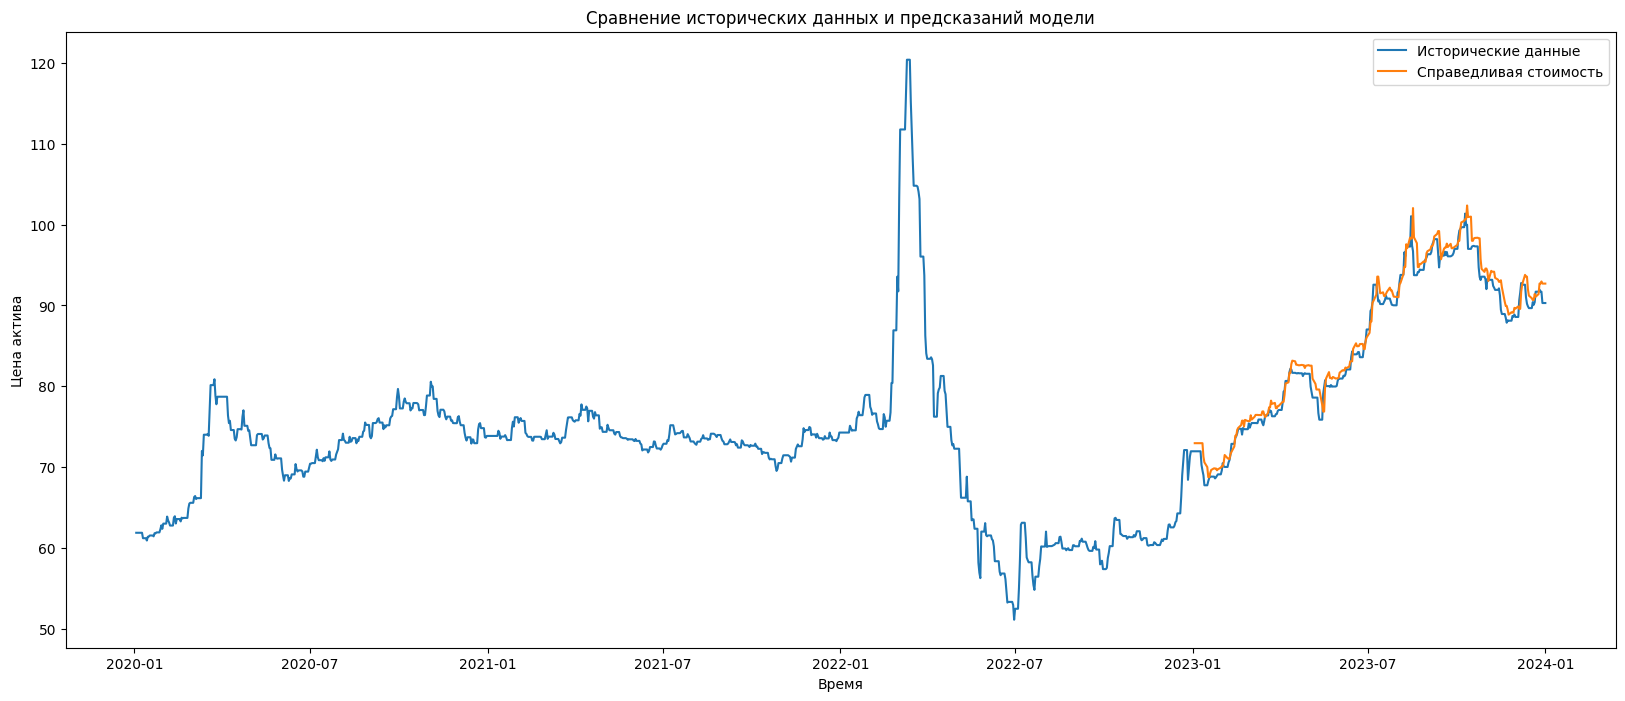

In [52]:
plt.figure(figsize = (20, 8))
plt.plot(df_assets['Курс_доллара_США'], label = 'Исторические данные')
plt.plot(fair_prices['Курс_доллара_США'], label = 'Справедливая стоимость')
plt.xlabel('Время')
plt.ylabel('Цена актива')
plt.title('Сравнение исторических данных и предсказаний модели')
plt.legend()
plt.show()

In [53]:
var_model.backtest()

Количество нарушений:  8

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 3.08%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел

### Горизонт планирования 10 день

In [56]:
var_model = VaRModel(df_assets, pca_risk_factor_df, currency, horizon = 10)
VaR, ES = var_model.calculate_VaR_ES()

100%|█████████████████████████████████████████| 251/251 [00:43<00:00,  5.78it/s]


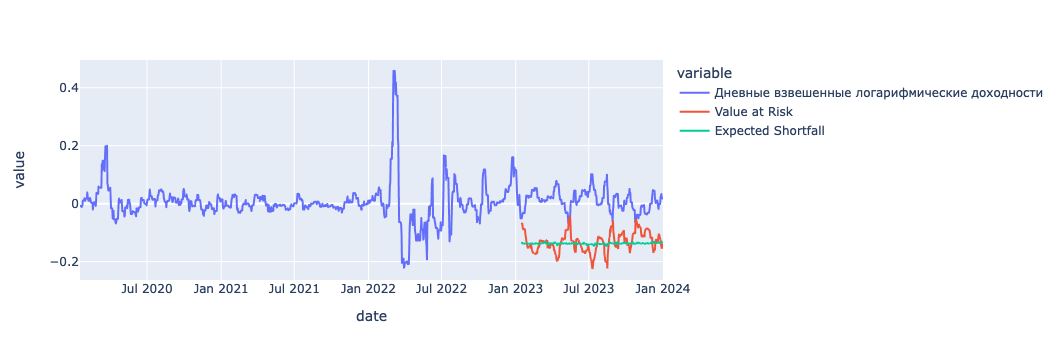

<Figure size 1600x800 with 0 Axes>

Дневные взвешенные логарифмические доходности  Value at Risk  \
date                                                                       
2020-01-17                                      -0.007920            NaN   
2020-01-20                                      -0.007917            NaN   
2020-01-21                                      -0.011973            NaN   
2020-01-22                                      -0.005852            NaN   
2020-01-23                                      -0.006765            NaN   
...                                                   ...            ...   
2023-12-26                                       0.023307      -0.124510   
2023-12-27                                       0.027324      -0.139568   
2023-12-28                                       0.032763      -0.149271   
2023-12-29                                       0.017944      -0.155605   
2024-01-01                                       0.017903      -0.137413   

            Expected Shortfall  
date                            
2020-01-17                 NaN  
2020-01-20                 NaN  
2020-01-21                 NaN  
2020-01-22                 NaN  
2020-01-23                 NaN  
...                        ...  
2023-12-26           -0.136097  
2023-12-27           -0.134908  
2023-12-28           -0.134913  
2023-12-29           -0.131017  
2024-01-01           -0.133926  

[1032 rows x 3 columns]

In [57]:
var_model.plot_VaR_ES()

In [58]:
var_model.backtest()

Количество нарушений:  4

Целевая доля нарушений: 1.00%

Наблюдаемая доля нарушений: 1.59%

Тест на покрытие: Не прошел

Тест на независимость: Не прошел